# Linear regression analysis

Import necessary libraries

In [1]:
import pandas as pd
import glob
from functools import reduce
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
regression = LinearRegression(normalize=True)
import seaborn as sns
import missingno as mno

sns.set(style="white")  

## Roadmap of this notebook: 
- EDA: which audience score data is best: RottenTomatoes, Metacritic or IMDb? *Note*: we say that anything normally distributed about a mean of 7 (that is seen as "average") in the movie industry, is OK.
- Use IMDb data
- Drop NA IMDb values (n=~300)
- Drop NA genre values (n=30)
- Train/val/test split
- One-hot-enconding of genre w/ target (IMDb rating) 
- Baseline linear regression: R^2 = 0.09
- 
  

In [2]:
mojo = pd.read_csv('data/mojo.csv')
imdb = pd.read_csv('data/imdb.csv')
metacritic = pd.read_csv('data/metacritic.csv')
tomato = pd.read_csv('data/rotten_tomatoes.csv')
heirloom = pd.read_csv('data/heirloom.csv')
mojo.rename(columns={"title": "mojo_title"}, inplace=True)
heirloom.set_index(['mojo_title'])
imdb.set_index(['mojo_title'])
metacritic.set_index(['mojo_title'])
tomato.set_index(['mojo_title'])
mojo.set_index(['mojo_title'])

mojo.head(1)

,mojo_title,domestic_revenue,international_revenue,world_revenue,distributor,opening_revenue,opening_theaters,budget,MPAA,genres,release_days
0,Made in France,"$9,956",NaN,"$9,956",Under The Milky Way,"$3,688",2 theaters,NaN,NaN,"Crime, Drama, Thriller","Sep 23, 2016"


# EDA of RottenTomatoes

In [3]:
tomato_final = tomato.merge(heirloom, on='mojo_title', how='left')

In [4]:
tomato_final = tomato_final.drop(['url_y', 'tomato_criticcount_x'], axis=1)

In [5]:
tomato_final = tomato_final.rename(columns={"tomato_criticcount_y":"tomato_criticcount", "url_x":"url"})

In [6]:
tomato_final = tomato_final.dropna(subset=['tomato_image'])

In [7]:
def get_img_url(df):  
    return re.findall('(?<=data-src).*$', df)[0][2:-2]
tomato_final['tomato_image'] = tomato_final['tomato_image'].apply(get_img_url)

/Users/liamisaacs/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[]

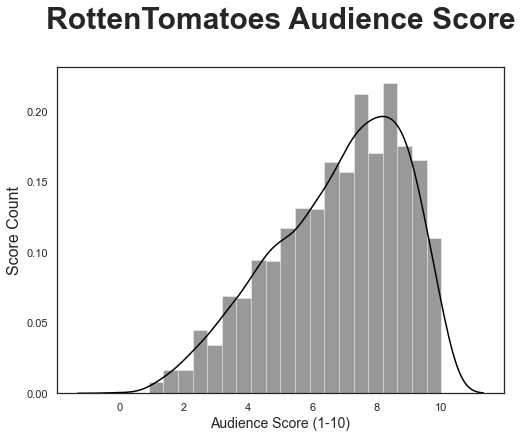

In [8]:
plt.figure(figsize=(8, 6))
sns.set_style(style='white') 
# plt.scatter(test_set_pred, y_test, alpha=.1,  scatter_kws={"color": "black"}, line_kws={"color": "red"})
ax = sns.distplot(tomato_final['tomato_audiencescore']/10, color="black")
ax.set_title("RottenTomatoes Audience Score", fontsize=30, weight='bold', y=1.1)

plt.xlabel('Audience Score (1-10)', fontsize=14)
plt.ylabel('Score Count', fontsize=16)
plt.plot()

## Rotten tomatoes is non-normal and is skewed for audience score.

## Let's check IMDb

In [9]:
imdb['imdbscore'].isna().sum()

1

In [10]:
imdb = imdb.drop(imdb[imdb['imdbscore']=='Link error'].index)

In [11]:
imdb['imdbscore'] = pd.to_numeric(imdb['imdbscore'])

/Users/liamisaacs/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[]

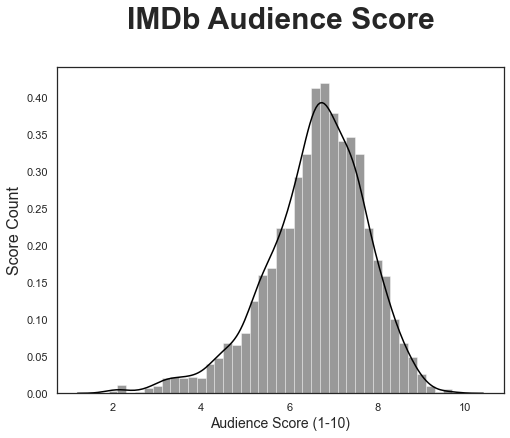

In [12]:
plt.figure(figsize=(8, 6))
sns.set_style(style='white') 
# plt.scatter(test_set_pred, y_test, alpha=.1,  scatter_kws={"color": "black"}, line_kws={"color": "red"})
ax = sns.distplot(imdb['imdbscore'], color="black")
ax.set_title("IMDb Audience Score", fontsize=30, weight='bold', y=1.1)

plt.xlabel('Audience Score (1-10)', fontsize=14)
plt.ylabel('Score Count', fontsize=16)
plt.plot()

### IMDb is normal, we can use IMDb

## Let's check Metacritic

In [13]:
metacritic.isna().sum()

mojo_title            0
mc_criticscore        1
mc_criticcount        1
mc_audiencescore      1
mc_audiencecount    383
dtype: int64

In [14]:
drop = ['tbd', 'Link error']
metacritic.drop(metacritic.index[metacritic['mc_criticscore'].isin(drop)], inplace = True)

In [15]:
metacritic['mc_criticscore'] = pd.to_numeric(metacritic['mc_criticscore'])

/Users/liamisaacs/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[]

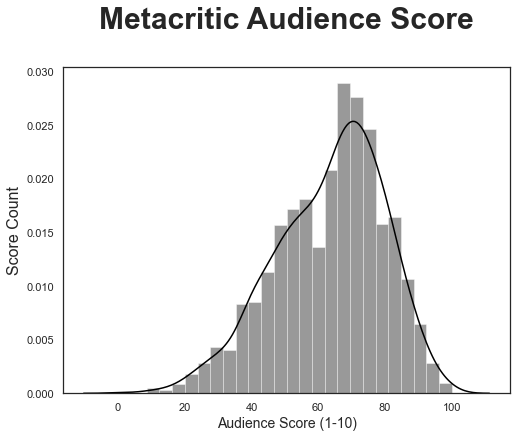

In [16]:
plt.figure(figsize=(8, 6))
sns.set_style(style='white') 
# plt.scatter(test_set_pred, y_test, alpha=.1,  scatter_kws={"color": "black"}, line_kws={"color": "red"})
ax = sns.distplot(metacritic['mc_criticscore'], color="black")
ax.set_title("Metacritic Audience Score", fontsize=30, weight='bold', y=1.1)

plt.xlabel('Audience Score (1-10)', fontsize=14)
plt.ylabel('Score Count', fontsize=16)
plt.plot()

### Metacritic is also fairly normal.

In [17]:
# This is for overlaying the three graphs, which seems un-necessary
# sns.set(font_scale = 2)

# sns.set_style(style='white') 
# fig, ax = plt.subplots(figsize=(15,10))
# sns.distplot( df["imdbscore"] , color="skyblue", label="IMDB's score",hist=None)
# sns.distplot( df["mc_audiencescore"]/10 , color="green", label="RottenTomatoe's audience score",hist=None)

# sns.distplot( df["tomato_audiencescore"]/10 , color="red", label="RottenTomatoe's audience score", hist=None)
# fig.legend(labels=['IMDB','Metacritic', 'RottenTomatoes'])
# ax.set_title("Review Distributions", fontsize=30, weight='bold', y=1.1)
# ax.set(xlabel="Audience Rating (scaled to 1-10)",
#        ylabel="KDE Estimate", xlim=(0, 10))
# sns.despine()

## Since Metacritic and IMDb are both normally distributed about a mean of 7, we will go with IMDb, as we have more IDMb data.

In [18]:
df = mojo.merge(imdb, on='mojo_title', how='left')

#This does not return 3107 rows, it returns 3369. I checked below that these duplicates are in fact the exact same
#across columns and that no information loss occurs.
#
#As a result, it is OK by me to just drop these duplicates.


## Null values

Missing values visualization (white = missing)

<AxesSubplot:>

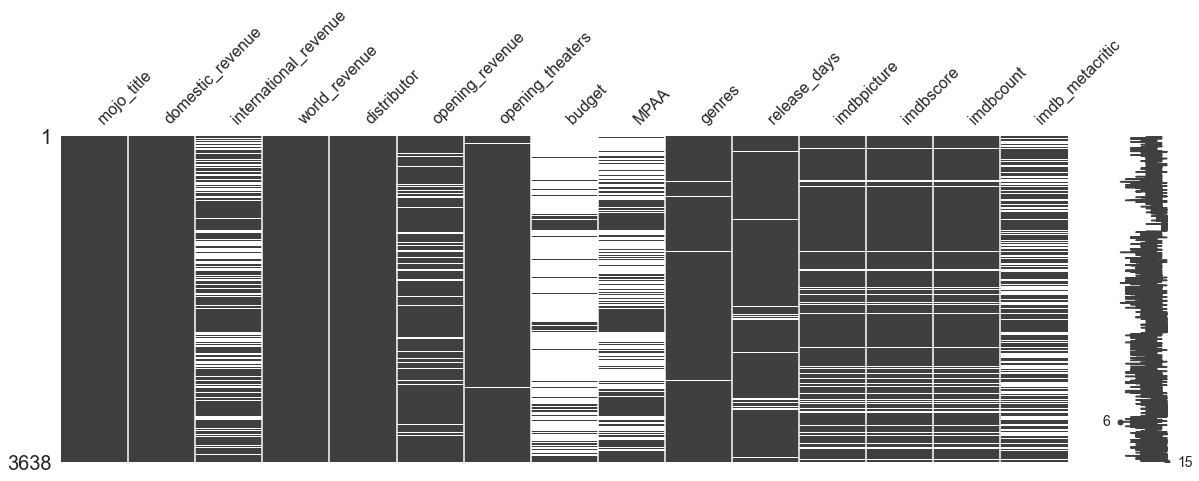

In [19]:
mno.matrix(df, figsize = (20, 6))


*Note*: this is probably because for IMDb we did not use a rigorous search algorithm to find each movie, we just guessed the url. The errors are independent and random, non-centarlized by movie, but that is why we see them at all.

We remove Budget, MPAA rating (too little data), and discard imdbpicture, imdbcount, and imdb_metacritic (irrelevant to our analysis). We will impute international revenue, imdbscore. 

In [20]:
df.drop(columns=['budget', 'MPAA', 'imdbpicture', 'imdbcount', 'imdb_metacritic', 'release_days', 'opening_theaters'], inplace=True)

<AxesSubplot:>

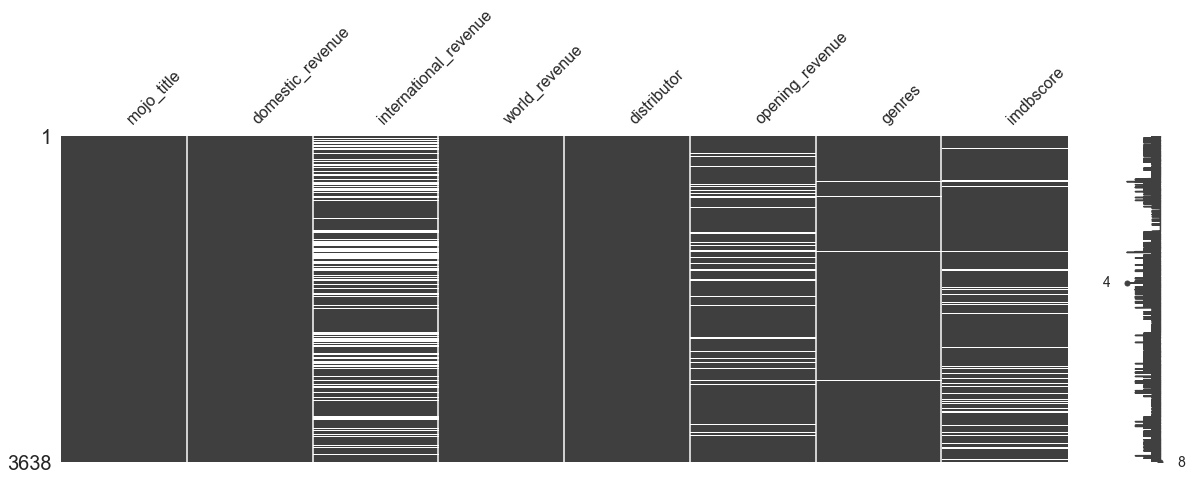

In [21]:
mno.matrix(df, figsize = (20, 6))


We cannot afford to impute any imdbscore, so we will drop NA from this column.

In [22]:
df = df.dropna(subset=['imdbscore'])

<AxesSubplot:>

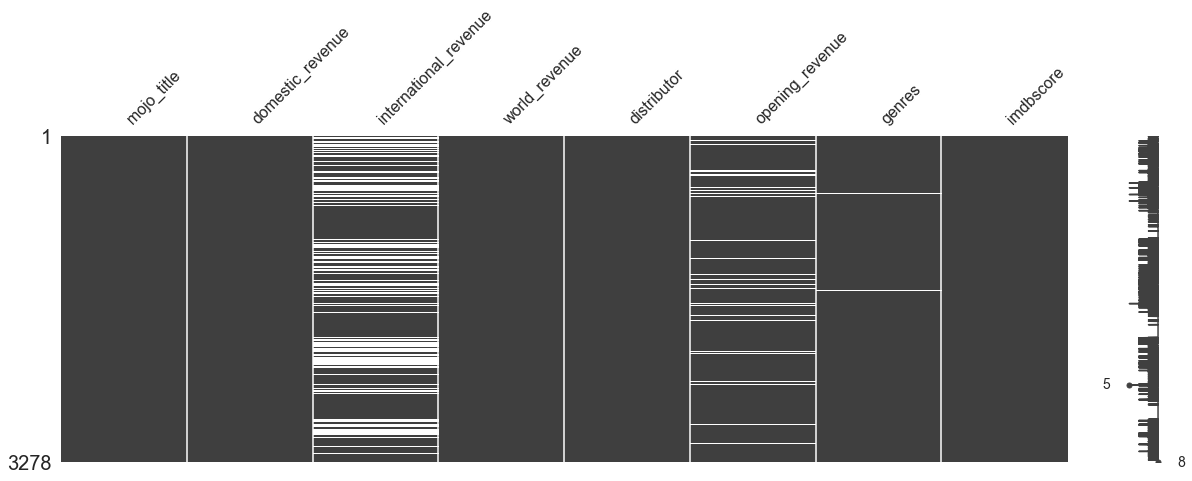

In [23]:
mno.matrix(df, figsize = (20, 6))


In [24]:
# turn $2,000 into 2000

# money = ['domestic_revenue', 'international_reveneue', 'world_revenue', 'opening_revenue']
# for i in range(0, len(money)):
#     df[money[i]] = df[money[i]].replace(',', '')
#     df[money[i]] = df[money[i]].replace('$', '')
#     df[money[i]] = pd.to_numeric(df[money[i]])

df['domestic_revenue'] = df['domestic_revenue'].str.replace(',', '')
df['domestic_revenue'] = df['domestic_revenue'].str.replace('$', '')
df['domestic_revenue'] = pd.to_numeric(df['domestic_revenue'])
df['international_revenue'] = df['international_revenue'].str.replace(',', '')
df['international_revenue'] = df['international_revenue'].str.replace('$', '')
df['international_revenue'] = pd.to_numeric(df['international_revenue'])
df['world_revenue'] = df['world_revenue'].str.replace(',', '')
df['world_revenue'] = df['world_revenue'].str.replace('$', '')
df['world_revenue'] = pd.to_numeric(df['world_revenue'])
df['opening_revenue'] = df['opening_revenue'].str.replace(',', '')
df['opening_revenue'] = df['opening_revenue'].str.replace('$', '')
df['opening_revenue'] = pd.to_numeric(df['opening_revenue'])

In [25]:
df

,mojo_title,domestic_revenue,international_revenue,world_revenue,distributor,opening_revenue,genres,imdbscore
0,Made in France,9956,NaN,9956,Under The Milky Way,3688.0,"Crime, Drama, Thriller",6.2
1,Realms,147,22296.0,22443,The Film Arcade,108.0,"Horror, Mystery",5.5
2,Postcards from London,5312,10236.0,15548,Strand Releasing,2686.0,Drama,5.1
3,Over the Limit,3243,NaN,3243,Film Movement,1402.0,"Documentary, Sport",7.4
4,Tall Tales from the Magical Garden of Antoon K...,220,14340506.0,14340726,Viva Pictures,NaN,"Adventure, Animation, Comedy, Family",4.6
...,...,...,...,...,...,...,...,...
3632,Star Wars: Episode IX - The Rise of Skywalker,515202542,558941706.0,1074144248,Walt Disney Studios Motion Pictures,177383864.0,"Action, Adventure, Fantasy, Sci-Fi",6.5
3633,Jumanji: The Next Level,320314960,479744747.0,800059707,Sony Pictures Entertainment (SPE),59251543.0,"Action, Adventure, Comedy, Fantasy",6.7
3635,1917,159227644,225679098.0,384906742,Universal Pictures,576216.0,"Drama, Thriller, War",8.3
3636,1917,159227644,225679098.0,384906742,Universal Pictures,576216.0,"Drama, Thriller, War",7.3


## Create a new df with just IMDB score (called "df_new")


In [26]:
df_new = df
df['domestic_international_ratio'] = df['domestic_revenue'] / df['international_revenue']
df_new = df_new.drop(columns=['mojo_title', 'international_revenue', 'domestic_revenue',
                             'opening_revenue'], axis=1)

#df_new['domestic_international_ratio'] = df['domestic_revenue'] / df['international_reveneue']

#let's drop revenues, as those present the risk of multicolinearity
# df_new = df_new.drop(columns=['domestic_revenue', 'international_reveneue', 'opening_revenue']).head(2)

In [27]:
df_new.head()

,world_revenue,distributor,genres,imdbscore,domestic_international_ratio
0,9956,Under The Milky Way,"Crime, Drama, Thriller",6.2,NaN
1,22443,The Film Arcade,"Horror, Mystery",5.5,0.006593
2,15548,Strand Releasing,Drama,5.1,0.518953
3,3243,Film Movement,"Documentary, Sport",7.4,NaN
4,14340726,Viva Pictures,"Adventure, Animation, Comedy, Family",4.6,0.000015


We will drop the 20 N/A values for genre.

In [28]:
df_new = df_new.dropna(subset=['genres'])

## One-hot-encoding of genre

In [29]:
df_new['imdbscore'].isnull().values.any()

False

In [30]:
df_new['imdbscore']

0       6.2
1       5.5
2       5.1
3       7.4
4       4.6
       ... 
3632    6.5
3633    6.7
3635    8.3
3636    7.3
3637    6.6
Name: imdbscore, Length: 3258, dtype: float64

In [31]:
# df['opening_theaters'] = df['opening_theaters'].str.extract(r'([^\s]+)')
# df['opening_theaters'] = df['opening_theaters'].str.replace(',', '')
# df['opening_theaters'] = pd.to_numeric(df['opening_theaters'])
genres = np.unique(', '.join(df_new['genres']).split(', '))
genres = np.delete(genres, np.where(genres == 'NA'))
for genre in genres:
    df_new[genre] = df_new['genres'].str.contains(genre).astype('int')
df_new.drop('genres', axis=1, inplace=True)

In [32]:
df_new.sample(10)

,world_revenue,distributor,imdbscore,domestic_international_ratio,Action,Adult,Adventure,Animation,Biography,Comedy,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
3595,61404394,Lionsgate,6.8,1.071562,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1069,177634,Icarus Films,7.6,11.992539,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1811,1439539,Neon,7.7,1.020632,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2432,19390,FilmBuff,5.9,12.280822,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
721,855421,Fathom Events,7.3,NaN,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2666,191678,Orion Pictures,5.5,15.553934,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1279,15552,Rialto Pictures,6.6,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2190,2048359754,Walt Disney Studios Motion Pictures,8.4,0.495651,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2534,46041,Rialto Pictures,7.5,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
598,173961069,Walt Disney Studios Motion Pictures,5.5,0.460603,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Genre is one-hot-encoded. Train/val/test split to give baseline R^2.

## Baseline linear regression w/ Genre

Validation method: Train / Validation / Test

In [33]:
#hold 20% for final testing
X, y = df_new, df_new['imdbscore']

#train test split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=10)

In [34]:
#split training into validation and train
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)

Target: IMDB score; features: genres; question: do people like one genre over the other?

In [35]:
target = df_new['imdbscore']
features = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 
               'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
               'News', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western']

**Baseline test on training data for linear regression**

In [36]:
depd = X_train.iloc[:, 4:30] # Remember that Python does not slice inclusive of the ending index.
depd

,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
2280,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
313,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1387,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1514,0,0,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,1,0
1341,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2562,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
582,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
987,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [37]:
pd.to_numeric(X_train.iloc[:, 2].fillna(0))

2280    5.4
313     6.7
1387    7.8
1514    6.5
1341    5.0
       ... 
218     6.8
2562    5.9
582     3.1
987     7.2
1136    6.9
Name: imdbscore, Length: 1954, dtype: float64

In [38]:
baseline = linear_model.LinearRegression()
baseline.fit(X=depd, y=y_train)
baseline.score(X=depd, y=y_train)

0.09790668635623756

**Feature engineering: add in interaction term between genres**

"Horror Thrillers" do better than Horror movies, we assume. If we interact every genre with every genre, and consider those interactions, our R^2 will inevitably go up.

In [39]:
def create_interactions(df):
    df_int = df.copy()
    for i in range(3, len(df.columns)-1):
        for j in range(i+1, len(df.columns)):
            name = str(df.columns[i]) + ' * ' + str(df.columns[j])
            df_int.loc[:, name] = df[str(df.columns[i+1])] * df[str(df.columns[j])]
    return df_int

In [40]:
X_train_interactions = create_interactions(X_train)

In [41]:
X_train_interactions.drop(columns=['distributor'], axis=1)

,world_revenue,imdbscore,domestic_international_ratio,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,...,Short * Sport,Short * Thriller,Short * War,Short * Western,Sport * Thriller,Sport * War,Sport * Western,Thriller * War,Thriller * Western,War * Western
2280,3981,5.4,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
313,47269,6.7,5.226979,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1387,36506,7.8,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1514,363307,6.5,6.134018,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1341,2195706,5.0,0.011173,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,2911800,6.8,0.031161,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2562,62398,5.9,NaN,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
582,260234,3.1,NaN,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
987,91522094,7.2,0.998610,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
X_train_interactions = X_train_interactions.drop(columns=['imdbscore'])

In [43]:
X_train_interactions = X_train_interactions.iloc[:, 3:380]

In [44]:
X_train_interactions.iloc[:, 26:380]

,domestic_international_ratio * Action,domestic_international_ratio * Adult,domestic_international_ratio * Adventure,domestic_international_ratio * Animation,domestic_international_ratio * Biography,domestic_international_ratio * Comedy,domestic_international_ratio * Crime,domestic_international_ratio * Documentary,domestic_international_ratio * Drama,domestic_international_ratio * Family,...,Short * Sport,Short * Thriller,Short * War,Short * Western,Sport * Thriller,Sport * War,Sport * Western,Thriller * War,Thriller * Western,War * Western
2280,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
313,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1387,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1514,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2562,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
582,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
987,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
baseline_with_interactions = linear_model.LinearRegression()
baseline_with_interactions.fit(X_train_interactions, y=y_train)
baseline_with_interactions.score(X_train_interactions, y=y_train)

0.18103101840627522

**R^2 was doubled or so by introducing interaction terms. Important to note that this is probably over-fitting to this model, since there are probably just a few that pertain to Short War films for example.**

Since it seems like the right direction, we'll add back in X_train_interactions to X_train.

In [47]:
X_train

,world_revenue,distributor,imdbscore,domestic_international_ratio,Action,Adult,Adventure,Animation,Biography,Comedy,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
2280,3981,Strand Releasing,5.4,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
313,47269,Metrograph Pictures,6.7,5.226979,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1387,36506,Entertainment One,7.8,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1514,363307,GKIDS,6.5,6.134018,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1341,2195706,Screen Media Films,5.0,0.011173,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,2911800,IFC Films,6.8,0.031161,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2562,62398,Shout! Factory,5.9,NaN,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
582,260234,Fathom Events,3.1,NaN,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
987,91522094,Lionsgate,7.2,0.998610,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


no domestic_international_ratio means there was no international release, so we can fill those to 0

In [65]:
X_train['domestic_international_ratio'].fillna(value=0, inplace=True)

/Users/liamisaacs/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Add back-in our interaction terms to X_train

In [69]:
X_train2 = X_train.merge(X_train_interactions.iloc[:, 26:380], how='inner', left_index=True, right_index=True)

In [49]:
#I wanted to use cv to find these interactions but this code fails

# regression = LinearRegression(normalize=True)
# crossvalidation = KFold(n=X.shape[0], n_folds=10, shuffle=True, random_state=1)

# df = pd.DataFrame(X_train.iloc[:, 3:31])
# baseline = np.mean(cross_val_score(regression, X_train, y_train, cv=crossvalidation, scoring='r2',
#  n_jobs=1))
# interactions = list()
# for i in X_train.iloc[:, 5:6]:
#  for j in X_train.iloc[:, 3:4]:
#   if i > j:
#    X_train['interaction'] = X_train[i] * X_train[j]
#    score = np.mean(cross_val_score(regression, X_train, y, scoring='r2',
#     cv=crossvalidation, n_jobs=1))
#    if score > baseline:
#     interactions.append((i, j, round(score,3)))
# print('Baseline R2: %.3f' % baseline)
# print('Top 10 interactions: %s' % sorted(interactions, key=lambda x:x[2],
#  reverse=True)[:10])

### Feature engineering: add-in another feature, distributors

Add-in distributors

In [71]:
distributors = df.distributor.value_counts()
distributors

Fathom Events             268
Warner Bros.              200
Universal Pictures        112
IFC Films                 103
Indican Pictures           81
                         ... 
FilmBuff                    1
OTL Releasing               1
CineLife Entertainment      1
The Film Collaborative      1
Altered Innocence           1
Name: distributor, Length: 264, dtype: int64

In [75]:
other_distributors = list(distributors[distributors <= 40].index)
print("Other distributor, defined as less than 10 movies/year, there were {}".format(len(other_distributors)))


Other distributor, defined as less than 10 movies/year, there were 244


In [90]:
X_train2['distributor'] = X_train2['distributor'].replace(other_distributors, 'Other')

In [ ]:
genres = np.unique(', '.join(df_new['genres']).split(', '))
genres = np.delete(genres, np.where(genres == 'NA'))
for genre in genres:
    df_new[genre] = df_new['genres'].str.contains(genre).astype('int')
df_new.drop('genres', axis=1, inplace=True)

In [52]:
count = df_new["distributor"].isna().sum()
print(count)

0


Fathom Events             268
Warner Bros.              200
Universal Pictures        112
IFC Films                 103
Indican Pictures           81
                         ... 
FilmBuff                    1
OTL Releasing               1
CineLife Entertainment      1
The Film Collaborative      1
Altered Innocence           1
Name: distributor, Length: 264, dtype: int64

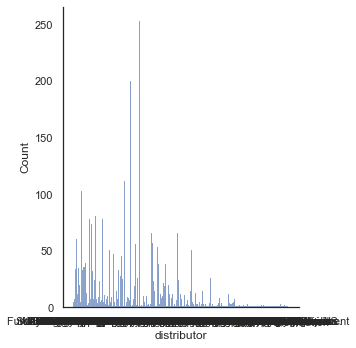

In [54]:
sns.displot(df_new, x="distributor")

229

In [57]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}')

In [58]:
X5 = df_new.copy()

X5['distributor'] = df_new['distributor'].replace(other_distributors, 'Other')
X5['distributor'] = X5['distributor'].str.replace(" ","")


In [59]:
X5[X5['mojo_title'] == 'Worlds Apart']

KeyError: 'mojo_title'

In [ ]:
X5 = pd.get_dummies(X5, columns=['distributor'])

In [ ]:
X5.columns

In [ ]:
X5


In [ ]:
add_in_more_features = X5.iloc[:, 10:]

In [ ]:
add_in_more_features.columns

In [ ]:
new_lr = LinearRegression()
new_lr.fit(add_in_more_features, target)
new_lr.score(add_in_more_features, target)


Nice, that raised our R^2 by .3!

In [ ]:
new_lr.coef_

What if I minimize the size of these coefficients..

LASSO/RIDGE regression

#1 lasso

In [ ]:
add_in_more_features.columns
more_features_list = add_in_more_features.columns.values.tolist()


In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X5, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [ ]:
lasso_model = Lasso(alpha = 0.01) # this is a VERY HIGH regularization strength!, wouldn't usually be used
lasso_model.fit(X_train.loc[:,more_features_list], y_train)
list(zip(more_features_list, lasso_model.coef_))

In [ ]:
test_set_pred = lasso_model.predict(X_test.loc[:,more_features_list])

def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(y_test, test_set_pred)

Yay some of the coefficients have been zeroed-out!

#2 Ridge

In [ ]:
lr_model_ridge = Ridge(alpha = 0.01)
lr_model_ridge.fit(X_train.loc[:,more_features_list], y_train)
list(zip(more_features_list, lr_model_ridge.coef_))



Minimizes the coefficients still, but still we have so many features the model becomes hard to read

In [ ]:
test_set_pred = lasso_model.predict(X_test.loc[:,more_features_list])


In [ ]:
%matplotlib inline
plt.figure(figsize=(8, 6))
sns.set_style(style='white') 
# plt.scatter(test_set_pred, y_test, alpha=.1,  scatter_kws={"color": "black"}, line_kws={"color": "red"})
ax = sns.regplot(x=test_set_pred, y=y_test, color="black")
ax.set_title("Residual plot of model", fontsize=30, weight='bold', y=1.1)

plt.xlabel('Predicted value', fontsize=14)
plt.ylabel('Actual value', fontsize=16)
plt.plot()

In [ ]:
df['predicted_imdb'] = lasso_model.prext()

In [ ]:
r2_score(y_test, test_set_pred)


In [ ]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(y_test, test_set_pred)

Tr > Te by .1, which indicates we are *overfitting*. We can use **stronger regularization** to combat this problem, we can try to manually change alpha, or we can find the best value of the regularization strength programmatically.

In [ ]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures


In [ ]:
poly = PolynomialFeatures(interaction_only=True)
poly.fit_transform(X_train.loc[:,more_features_list])


In [ ]:
#plot the curve of validation error as alpha changes

plt.plot(np.log10(alphalist), err_vec_val)

In [ ]:
## This is the minimum error achieved on the validation set 
## across the different alpha values we tried
np.min(err_vec_val)

In [ ]:
## This is the value of alpha that gave us the lowest error

alphalist[np.argmin(err_vec_val)]


### Cross-validate with LassoCV to find the best alpha

Instead of using a program to plot error as we change alpha (on validation data), and taking the minimum of that slope, we can use cross-validation. Here, we run 5-fold cross-validation to retrive the optimal value of alpha

In [ ]:
alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_train.loc[:,more_features_list], y_train)

In [ ]:
lasso_model.alpha_


By cross-validating and by using calculus (find min.), we reason the best value of alpha we will get is 0.01.

Refit it...

In [ ]:
list(zip(X_train.columns, lasso_model.coef_))


In [ ]:
mae(y_test, test_set_pred)


In [ ]:
X5

In [ ]:
y = X5['imdbscore']


In [ ]:
len(y)

In [ ]:
lasso_model = Lasso(alpha = 0.01) # this is a VERY HIGH regularization strength!, wouldn't usually be used
lasso_model.fit(X5.loc[:,more_features_list], y)

X5['pred'] = lasso_model.predict(X5.loc[:,more_features_list])

In [ ]:
X5

In [ ]:
df_final = df.merge(X5, on="mojo_title", how="right")

In [ ]:
df_final.columns

In [ ]:
r2_score(y_test, test_set_pred)


In [ ]:
from sklearn.linear_model import lars_path


Stepwise regression is a variable selection procedure for independent variables. It consists of a series of steps designed to find the most useful X-variables to include in a regression model.

It's a *forward selection* process since once a variable is selected it cannot be removed from the model.



In [ ]:
X, y = df_new, df_new['imdbscore']

In [ ]:
lasso_model = Lasso(alpha = 0.01) # this is a VERY HIGH regularization strength!, wouldn't usually be used
lasso_model.fit(X.loc[:,more_features_list], y)
list(zip(more_features_list, lasso_model.coef_))

In [ ]:
X5['pred'] = test_

In [ ]:
mangodb_df = df.merge()

can always get back to title since index order is const. || look at residuals then join movie titles back in

--

- use standard scaler & a couple lines of code to incorporate LASSO/RIDGE regression
- 

- ratio btwn domestic and international?
- complex movies who don't share the same language
- easy-acceptable movies 
- interactions, horror by this studio is good, mine those sorts of conclusions
- not expecting .8, get it as high as possible
- what movies I can predict well, which ones I can't


In [ ]:
df.info

In [ ]:
df = df.dropna(subset=['imdbscore'])

In [ ]:
df_new.info

In [ ]:
df['imdbscore']